In [1]:
import scarlet
import galsim
from astropy import wcs as WCS
import galsim_compare_tools as gct
import time
import pickle

In [2]:
%pylab inline
data_dir='/Users/remy/Desktop/LSST_Project/GalSim/examples/data'
#Reference catalog for simulations
cat = galsim.COSMOSCatalog(dir=data_dir, file_name = 'real_galaxy_catalog_23.5_example.fits')
#Survey dictionaries
HST, EUCLID, WFIRST, HSC, LSST = gct.load_surveys()
#CHannels
channel_hr = ['hr']
channel_lr = ['lr']
channels = channel_lr+channel_hr

matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')
matplotlib.rc('xtick', labelsize=20) 

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Shapes tested for timing
shapes = [20, 30, 50, 70, 100, 150, 200]
#List of surveys
surveys = [HST, EUCLID, WFIRST, HSC, LSST]
#Size of the psf (pixels on-a-side)
npsf = 41
# Dictionary for storing results
structure = {'survey_hr':[], 'survey_lr': [], 'n_hr': [], 'n_lr': [], 's_mean': [], 's_std': [], 
             'g_mean': [], 'g_std': []}

#Timing for all combinations of high-low resolution images and all shapes in `shapes`
for nhr in shapes:
    for k, surveyhr in enumerate(surveys):
        print(nhr, surveyhr)
        for g, surveylr in enumerate(surveys[k+1:]):
            print(surveylr)
            # Making sure that the lr image spans roughly the same area on the sky as the hr image.
            nlr = int(nhr*surveyhr['pixel']/surveylr['pixel'])
            
            # Make simulations, picks a galaxy at random
            r = np.random.rand(1)*90
            data_hr, data_lr, psf_hr, psf_lr, angle = gct.mk_sim(int(r), surveyhr, surveylr, (nhr, nhr), 
                                                                 (nlr, nlr), npsf, cat)

            # scarlet setup
            obs_lr, obs_hr = gct.setup_scarlet(data_hr, data_lr, psf_hr, psf_lr, channels)
    
            # Galsim setup:
            ## GSO from psf_hr for galsim
            psf_hr_galsim = galsim.InterpolatedImage(galsim.Image(psf_hr[0]), 
                                               scale = surveyhr['pixel'], use_true_center = False)
            ## deconvolution kernel for diff kernel
            deconv = galsim.Deconvolve(psf_hr_galsim)
            ## Interpolation of low resolution psf at high resolution
            psf_lr_hr = galsim.InterpolatedImage(galsim.Image(psf_lr[0]), 
                                               scale = surveylr['pixel'], use_true_center = False)
            ## Difference kernel from galsim
            diff_gal = galsim.Convolve(deconv, psf_lr_hr)
        
            # Scarlet timing
            t_s = %timeit -n 100 -o obs_lr.render(data_hr.array[None,:,:])
            s_mean = np.array(t_s.all_runs).mean()/t_s.loops
            s_std = np.array(t_s.all_runs).std()/t_s.loops 
            # Galsim timing
            t_g = %timeit -n 100 -o gct.interp_galsim(data_hr, data_lr, diff_gal, angle, surveyhr['pixel'], surveylr['pixel'])
            g_mean = np.array(t_g.all_runs).mean()/t_g.loops 
            g_std = np.array(t_g.all_runs).std()/t_g.loops
            
            #Storage
            structure['survey_hr'].append(surveyhr) 
            structure['survey_lr'].append(surveylr) 
            structure['n_hr'].append(nhr) 
            structure['n_lr'].append(nlr)
            structure['s_mean'].append(s_mean)
            structure['s_std'].append(s_std)
            structure['g_mean'].append(g_mean) 
            structure['g_std'].append(g_std)

20 {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
{'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
1.21 ms ± 64 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.06 ms ± 580 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}
1.35 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.11 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}
1.05 ms ± 52.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.81 ms ± 536 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}
859 µs ± 42.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.43 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
20 {'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
{'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}
1.79 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.7 ms

7.51 ms ± 404 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
70 {'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}
{'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}
22.7 ms ± 647 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.84 ms ± 409 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
70 {'name': 'LSST', 'pixel': 0.2, 'psf': 0.7}
100 {'name': 'HST', 'pixel': 0.06, 'psf': 0.074}
{'name': 'EUCLID', 'pixel': 0.1, 'psf': 0.16}
33.3 ms ± 478 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.2 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'WFIRST', 'pixel': 0.11, 'psf': 0.18589999999999998}
30.9 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
10 ms ± 474 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'HSC', 'pixel': 0.167, 'psf': 0.62}
22.3 ms ± 700 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.44 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
{'name': 'LSST', 'pixel

<Figure size 1080x1080 with 0 Axes>

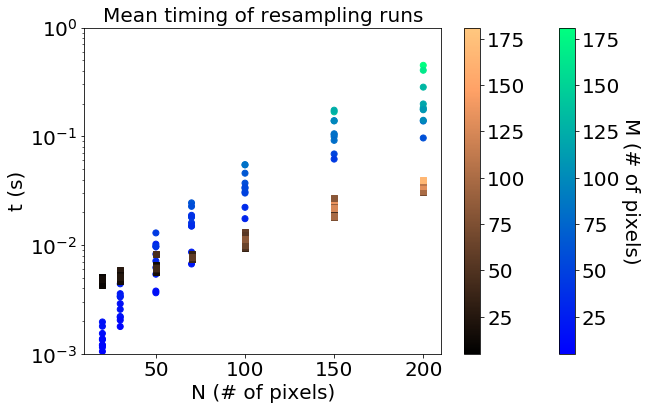

<Figure size 1080x1080 with 0 Axes>

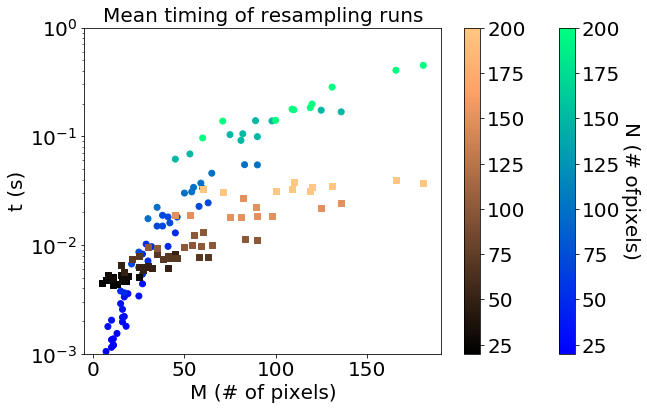

In [4]:
#Saving results
import pickle
afile = open('Timings_npsf='+str(npsf)+'.pkl', 'wb')
pickle.dump(structure, afile)
afile.close()

#Reading results
n_hrs = np.array(structure['n_hr'])
n_lrs = np.array(structure['n_lr'])
s_mean = (np.array(structure['s_mean']))
s_std = np.array(structure['s_std'])
g_mean = np.array(structure['g_mean'])
g_std = np.array(structure['g_std'])

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.close()
#Plotting results. Mean timing of resampling runs as a function of N
plt.figure(0, figsize = (15,15))
plt.subplots(figsize=(10, 6))
#ax2.errorbar(n_lrs, s_mean, yerr = s_std, capsize = 2, fmt = 'o', label = 'scarlet')
sc1 = plt.scatter(n_hrs, s_mean,c = n_lrs, marker = 'o', cmap = 'winter')
#ax2.errorbar(n_lrs, g_mean, yerr = g_std, capsize = 2, fmt = 's', label = 'galsim')
sc2 = plt.scatter(n_hrs, g_mean,c = n_lrs, marker = 's', cmap = 'copper')
plt.yscale('log')
cbar = plt.colorbar(sc1)
plt.colorbar(sc2)
cbar.set_label('M (# of pixels)', rotation=270, labelpad = 20, fontsize = 20)
# Adding plotting parameters
plt.title('Mean timing of resampling runs', fontsize=20)
plt.xlabel('N (# of pixels)', fontsize=20)
plt.ylabel('t (s)', fontsize=20)
plt.ylim([0.001,1])
plt.show()

#Plotting results. Mean timing of resampling runs as a function of M
plt.figure(1, figsize = (15,15))
plt.subplots(figsize=(10, 6))
#ax2.errorbar(n_lrs, s_mean, yerr = s_std, capsize = 2, fmt = 'o', label = 'scarlet')
sc1 = plt.scatter(n_lrs, s_mean,c = n_hrs, marker = 'o', cmap = 'winter')
#ax2.errorbar(n_lrs, g_mean, yerr = g_std, capsize = 2, fmt = 's', label = 'galsim')
sc2 = plt.scatter(n_lrs, g_mean,c = n_hrs, marker = 's', cmap = 'copper')
plt.yscale('log')
cbar = plt.colorbar(sc1)
plt.colorbar(sc2)
cbar.set_label('N (# ofpixels)', rotation=270, fontsize = 20, labelpad = 20)
# Adding plotting parameters
plt.title('Mean timing of resampling runs', fontsize=20)
plt.xlabel('M (# of pixels)', fontsize=20)
plt.ylabel('t (s)', fontsize=20)
plt.savefig('galsim_scarlet_timing.png')
plt.ylim(0.001,1)
plt.show()


<Figure size 1080x1080 with 0 Axes>

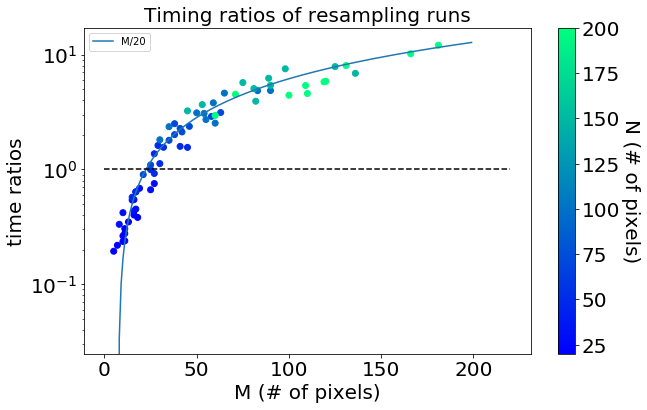

<Figure size 1080x1080 with 0 Axes>

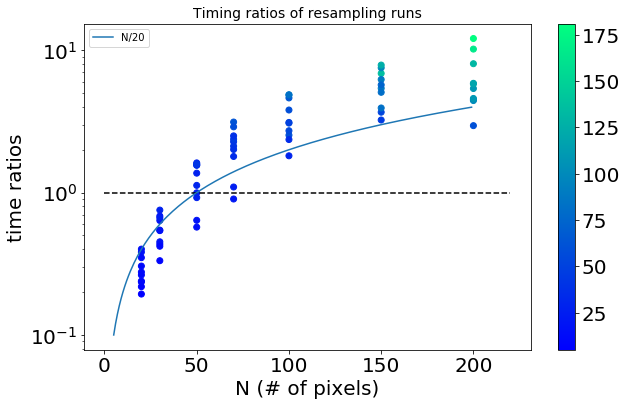

<Figure size 1080x1080 with 0 Axes>

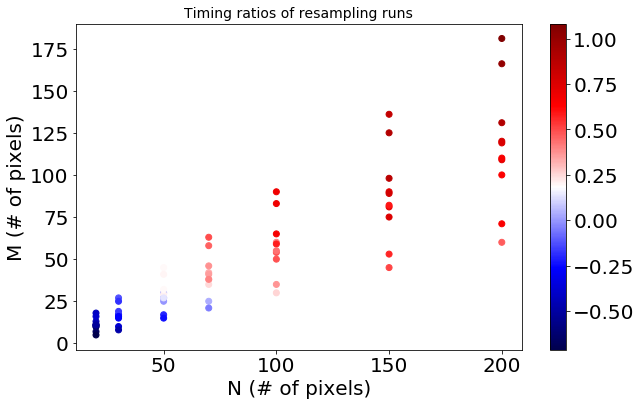

In [33]:
#Timing ratios as a function of M
plt.figure(2, figsize = (15,15))
fig2, ax2 = plt.subplots(figsize=(10, 6))
sc1 = ax2.scatter(n_lrs, s_mean/g_mean,c = n_hrs, marker = 'o', cmap = 'winter')
plot((np.arange(5,200)), (np.arange(5,200))/15-0.5, label = 'M/15')
#plot((np.arange(5,200)), (np.arange(5,200))/30, label = 'M/30')
plt.legend()
yscale('log')
cbar = colorbar(sc1)
plot([0,220], [1,1], '--k')
cbar.set_label('N (# of pixels)', rotation=270, fontsize = 20, labelpad = 20)
# Adding plotting parameters
ax2.set_title('Timing ratios of resampling runs', fontsize=20)
ax2.set_xlabel('M (# of pixels)', fontsize=20)
ax2.set_ylabel('time ratios', fontsize=20)
savefig('galsim_scarlet_ratio.png')
show()

#Timing ratios as a function of N
figure(3, figsize = (15,15))
fig2, ax2 = plt.subplots(figsize=(10, 6))
sc1 = ax2.scatter(n_hrs, s_mean/g_mean,c = n_lrs, marker = 'o', cmap = 'winter')
yscale('log')
colorbar(sc1)
plot([0,220], [1,1], '--k')
plot((np.arange(5,200)),(np.arange(5,200))/50, '-', label = 'N/20')
# Adding plotting parameters
ax2.set_title('Timing ratios of resampling runs', fontsize=14)
plt.legend()
ax2.set_xlabel('N (# of pixels)', fontsize=20)
ax2.set_ylabel('time ratios', fontsize=20)
show()

#Colour representation of the colour ratios
figure(4, figsize = (15,15))
fig2, ax2 = plt.subplots(figsize=(10, 6))
sc1 = ax2.scatter(n_hrs, n_lrs,c = np.log10(s_mean/g_mean), marker = 'o', cmap = 'seismic')

colorbar(sc1)
# Adding plotting parameters
ax2.set_title('Timing ratios of resampling runs', fontsize=14)
ax2.set_xlabel('N (# of pixels)', fontsize=20)
ax2.set_ylabel('M (# of pixels)', fontsize=20)
show()